## Molecule odor prediction via GINs with self-supervised contrastive pretraining
*Stanford CS224W project by Sarah Chen, Matthew Ding, and Cathy Zhou*

In [2]:
# config settings 
use_pretraining = True 

### Installations

In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb
!pip install pyrfume
!git clone https://github.com/paridhimaheshwari2708/GraphSSL.git

/Users/cathyzhou/miniforge3/envs/graph/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch has version 1.13.1
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /private/var/folders/ts/5tf0q1bj7dxbchwt8wdwz2sr0000gn/T/pip-req-build-qaq7184o
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /private/var/folders/ts/5tf0q1bj7dxbchwt8wdwz2sr0000gn/T/pip-req-build-qaq7184o
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 5f4a21c96e91bb4d974b7ab5f65ebabce9effd38
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909758 sha256=93c917ddc481dd1874228cb5e6befb51a1d9bb645794f5150ea5ce859b679f92
  Stored in directory: /private/var/folders/ts/5tf0q1bj7dxbchwt8wdwz2sr0000gn

In [3]:
import torch_geometric
torch_geometric.__version__

'2.3.0'

In [4]:
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd

from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool

import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tqdm import tqdm

torch_geometric.seed.seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# TODO: for now mount drive, but replace this with GitHub repo and %cd soon! 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'CS224W'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/CS224W/GNNose/src')
sys.path.append("/content/GraphSSL/")

ModuleNotFoundError: No module named 'google'

### Load the dataset

In [12]:
# load and split the dataset 
from odor_data import get_graph_data

graph_list = get_graph_data('lw')
train_set, val_set, test_set = torch.utils.data.random_split(graph_list, [0.7, 0.1, 0.2])

batch_size = 256 # TODO

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)


### Load the model

In [13]:
# set hyperparameters
in_channels = list(graph_list[2].x.shape)[-1]
out_channels = 1 # list(graph_list[2].y.shape)[1]
# TODO
hidden_channels = 64
num_layers = 1
dropout_p = 0.5
pooling_type = 'max'

In [15]:
# initialize model 
from odor_model import ScentClassifier

model = ScentClassifier(
    in_channels,
    hidden_channels, 
    num_layers, 
    out_channels,
    dropout=dropout_p,
    pooling_type=pooling_type,
)
model = model.to(device)

### Apply pretraining

In [17]:
# apply pretraining 
if use_pretraining:
    from odor_pretrain import build_pretraining_loader, pretrain
    from odor_model import PretrainingGIN
    
    pretrain_epochs = 120
    pretrain_batch_size = 256
    pretrain_lr = 1e-4
    pretrain_weight_decay = 1e-5

    pretrain_train_loader = build_pretraining_loader(train_set, "train", batch_size=batch_size)
    pretrain_val_loader = build_pretraining_loader(val_set, "val", batch_size=batch_size)

    pretrain_model = PretrainingGIN(
        in_channels, 
        hidden_channels, 
        num_layers, 
        out_channels,
        dropout=dropout_p
    ).to(device)

    pretrain_optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=pretrain_lr, weight_decay=pretrain_weight_decay)

    val_losses = []
    for epoch in tqdm(range(pretrain_epochs)):
        train_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "train", pretrain_train_loader, device)
        val_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "val", pretrain_val_loader, device)
        log = "Epoch {}, Train Loss: {:.3f}, Val Loss: {:.3f}"
        print(log.format(epoch, train_loss, val_loss))

        val_losses.append(val_loss)
    plt.plot(range(len(val_losses)), val_losses)
    plt.title(f"../pretraining/best_{epoch}_{hidden_channels}_{num_layers}_{batch_size}_{dropout_p}_{pretrain_lr}_{pretrain_weight_decay}")
    plt.show()


    model.gnn.load_state_dict(
        pretrain_model.gnn.state_dict()
    )


# samples in train subset: 2466
# samples in val subset: 352


  0%|          | 0/120 [00:00<?, ?it/s]


AssertionError: Torch not compiled with CUDA enabled

### Finetune on labeled data

  2%|▏         | 1/60 [00:00<00:19,  3.07it/s]

Epoch 0, Loss 0.040288806831749686


  3%|▎         | 2/60 [00:00<00:18,  3.20it/s]

Epoch 1, Loss 0.03828838213806895


  5%|▌         | 3/60 [00:00<00:17,  3.23it/s]

Epoch 2, Loss 0.03811069010528045


  7%|▋         | 4/60 [00:01<00:17,  3.13it/s]

Epoch 3, Loss 0.03704132264161245


  8%|▊         | 5/60 [00:01<00:17,  3.08it/s]

Epoch 4, Loss 0.036224382057097125


 10%|█         | 6/60 [00:01<00:17,  3.12it/s]

Epoch 5, Loss 0.035225715660410786


 12%|█▏        | 7/60 [00:02<00:17,  3.09it/s]

Epoch 6, Loss 0.034818799923032835


 13%|█▎        | 8/60 [00:02<00:16,  3.13it/s]

Epoch 7, Loss 0.03383284841044009


 15%|█▌        | 9/60 [00:02<00:16,  3.18it/s]

Epoch 8, Loss 0.03265778494383974


 17%|█▋        | 10/60 [00:03<00:15,  3.27it/s]

Epoch 9, Loss 0.032731414518023735


 18%|█▊        | 11/60 [00:03<00:17,  2.84it/s]

Epoch 10, Loss 0.03191575072010842


 20%|██        | 12/60 [00:04<00:19,  2.51it/s]

Epoch 11, Loss 0.03290212241402508


 22%|██▏       | 13/60 [00:04<00:20,  2.33it/s]

Epoch 12, Loss 0.032905578226552004


 23%|██▎       | 14/60 [00:05<00:20,  2.21it/s]

Epoch 13, Loss 0.031512641752046586


 25%|██▌       | 15/60 [00:05<00:20,  2.15it/s]

Epoch 14, Loss 0.03216334773772921


 27%|██▋       | 16/60 [00:06<00:20,  2.10it/s]

Epoch 15, Loss 0.032883250220268605


 28%|██▊       | 17/60 [00:06<00:20,  2.06it/s]

Epoch 16, Loss 0.03150273394217263


 30%|███       | 18/60 [00:07<00:20,  2.03it/s]

Epoch 17, Loss 0.032319883167115246


 32%|███▏      | 19/60 [00:07<00:20,  2.01it/s]

Epoch 18, Loss 0.03237776396628424


 33%|███▎      | 20/60 [00:08<00:20,  2.00it/s]

Epoch 19, Loss 0.030575950457038478


 35%|███▌      | 21/60 [00:08<00:19,  1.99it/s]

Epoch 20, Loss 0.03139047108330769


 37%|███▋      | 22/60 [00:09<00:18,  2.01it/s]

Epoch 21, Loss 0.030722691194854514


 38%|███▊      | 23/60 [00:09<00:16,  2.26it/s]

Epoch 22, Loss 0.030199620362132522


 40%|████      | 24/60 [00:09<00:14,  2.47it/s]

Epoch 23, Loss 0.029816347510468542


 42%|████▏     | 25/60 [00:10<00:13,  2.66it/s]

Epoch 24, Loss 0.03022476665778365


 43%|████▎     | 26/60 [00:10<00:12,  2.79it/s]

Epoch 25, Loss 0.03070705225094488


 45%|████▌     | 27/60 [00:10<00:11,  2.91it/s]

Epoch 26, Loss 0.029132103011169187


 47%|████▋     | 28/60 [00:11<00:10,  3.00it/s]

Epoch 27, Loss 0.030694221348078


 48%|████▊     | 29/60 [00:11<00:10,  3.09it/s]

Epoch 28, Loss 0.02967771493798818


 50%|█████     | 30/60 [00:11<00:09,  3.11it/s]

Epoch 29, Loss 0.027252843876921444


 52%|█████▏    | 31/60 [00:11<00:09,  3.04it/s]

Epoch 30, Loss 0.027976212420312736


 53%|█████▎    | 32/60 [00:12<00:09,  3.08it/s]

Epoch 31, Loss 0.028980595448688095


 55%|█████▌    | 33/60 [00:12<00:08,  3.02it/s]

Epoch 32, Loss 0.02960826319983019


 57%|█████▋    | 34/60 [00:12<00:08,  3.07it/s]

Epoch 33, Loss 0.029210466344667854


 58%|█████▊    | 35/60 [00:13<00:08,  3.12it/s]

Epoch 34, Loss 0.029654765651173837


 60%|██████    | 36/60 [00:13<00:07,  3.15it/s]

Epoch 35, Loss 0.03146947252005943


 62%|██████▏   | 37/60 [00:13<00:07,  3.15it/s]

Epoch 36, Loss 0.030946196720837968


 63%|██████▎   | 38/60 [00:14<00:07,  3.11it/s]

Epoch 37, Loss 0.030736780321317676


 65%|██████▌   | 39/60 [00:14<00:06,  3.13it/s]

Epoch 38, Loss 0.028516458672231904


 67%|██████▋   | 40/60 [00:14<00:06,  3.12it/s]

Epoch 39, Loss 0.030077616180333295


 68%|██████▊   | 41/60 [00:15<00:06,  3.16it/s]

Epoch 40, Loss 0.032451267660099224


 70%|███████   | 42/60 [00:15<00:05,  3.18it/s]

Epoch 41, Loss 0.030212314169482304


 72%|███████▏  | 43/60 [00:15<00:05,  3.17it/s]

Epoch 42, Loss 0.029013003746088405


 73%|███████▎  | 44/60 [00:16<00:04,  3.22it/s]

Epoch 43, Loss 0.028492747528806317


 75%|███████▌  | 45/60 [00:16<00:04,  3.20it/s]

Epoch 44, Loss 0.027910369059368546


 77%|███████▋  | 46/60 [00:16<00:04,  3.17it/s]

Epoch 45, Loss 0.026984715790450815


 78%|███████▊  | 47/60 [00:17<00:04,  3.19it/s]

Epoch 46, Loss 0.028185559788662926


 80%|████████  | 48/60 [00:17<00:03,  3.21it/s]

Epoch 47, Loss 0.026130030625057917


 82%|████████▏ | 49/60 [00:17<00:03,  3.23it/s]

Epoch 48, Loss 0.027727484799746276


 83%|████████▎ | 50/60 [00:17<00:03,  3.25it/s]

Epoch 49, Loss 0.028013067910657698


 85%|████████▌ | 51/60 [00:18<00:02,  3.21it/s]

Epoch 50, Loss 0.027180813621527185


 87%|████████▋ | 52/60 [00:18<00:02,  3.25it/s]

Epoch 51, Loss 0.028597001031657496


 88%|████████▊ | 53/60 [00:18<00:02,  3.21it/s]

Epoch 52, Loss 0.02828940703244298


 90%|█████████ | 54/60 [00:19<00:01,  3.11it/s]

Epoch 53, Loss 0.029977961274925906


 92%|█████████▏| 55/60 [00:19<00:01,  2.64it/s]

Epoch 54, Loss 0.030710628529631405


 93%|█████████▎| 56/60 [00:20<00:01,  2.42it/s]

Epoch 55, Loss 0.02991280629203654


 95%|█████████▌| 57/60 [00:20<00:01,  2.28it/s]

Epoch 56, Loss 0.029308394117270268


 97%|█████████▋| 58/60 [00:21<00:00,  2.17it/s]

Epoch 57, Loss 0.028268388491380726


 98%|█████████▊| 59/60 [00:21<00:00,  2.11it/s]

Epoch 58, Loss 0.02794422372414248


100%|██████████| 60/60 [00:22<00:00,  2.69it/s]

Epoch 59, Loss 0.026547945715601814


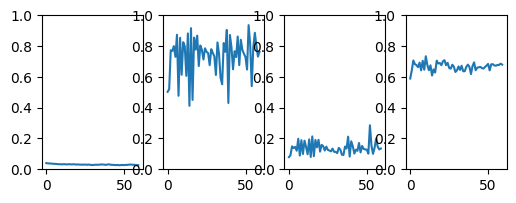

In [21]:
# train the model 
from odor_train import train, test
from torch_ema import ExponentialMovingAverage

num_epochs = 60
lr = 0.001
weight_decay = 1e-5

roc_scores, f1_scores, accs, losses = [], [], [], []
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
ema = ExponentialMovingAverage(model.parameters(), decay=0.995)


roc_scores = []
for epoch in tqdm(range(num_epochs)):
    loss = train(model, optimizer, train_loader, device, weighted_BCE=True)
    train_acc, train_preds, train_true  = test(model, train_loader, device)
    test_acc, test_preds, test_true = test(model, test_loader, device)
    # log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
    log = "Epoch {}, Loss {}"
    print(log.format(epoch, loss))


    # bootrapped ROC AUC score over entire test set
    _, whole_test_preds, whole_test_true = test(
        model, DataLoader(test_set, batch_size=len(test_set), shuffle=True), device)
    whole_test_preds = whole_test_preds.squeeze()
    whole_test_true = whole_test_true.squeeze()
    rocauc_score = roc_auc_score(whole_test_true.cpu(), whole_test_preds.cpu())
    f1 = f1_score(whole_test_true.cpu(), whole_test_preds.cpu())

    roc_scores.append(rocauc_score)
    f1_scores.append(f1)
    accs.append(accuracy_score(whole_test_true.cpu(), whole_test_preds.cpu()))
    losses.append(loss)

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i, (name, metric) in enumerate([
    ('loss', losses), ('acc', accs), ('f1', f1_scores), ('roc', roc_scores)
]):
    ax[i].plot(range(len(metric)), metric)
    ax[i].set_ylim((0, 1))
